In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:23<00:00, 148MB/s]
100% 2.29G/2.29G [00:23<00:00, 104MB/s]
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 99% 660M/663M [00:09<00:00, 71.9MB/s]
100% 663M/663M [00:09<00:00, 70.0MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip &> /dev/null
!unzip tuberculosis-tb-chest-xray-dataset.zip &> /dev/null

In [ ]:
 !mv ./TB_Chest_Radiography_Database/Normal ./TB_Chest_Radiography_Database/NORMAL

In [ ]:
!mv ./TB_Chest_Radiography_Database/Tuberculosis ./TB_Chest_Radiography_Database/TUBERCULOSIS

In [ ]:
!rm ./TB_Chest_Radiography_Database/Normal.metadata.xlsx ./TB_Chest_Radiography_Database/README.md.txt ./TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx

In [ ]:
data_chestxray_dir = "./chest_xray/chest_xray/"
data_chesttb_dir = "./TB_Chest_Radiography_Database/"

In [ ]:
import os
import shutil
import random

# Paths to the original folders
classes_tbchest = ['NORMAL', 'TUBERCULOSIS']

# Paths for the new folders
base_dir_tbchest = 'chest_tb'
train_dir = os.path.join(base_dir_tbchest, 'train')
val_dir = os.path.join(base_dir_tbchest, 'val')
test_dir = os.path.join(base_dir_tbchest, 'test')

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes_tbchest:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Function to split data
def split_data(class_dir, train_dir, val_dir, test_dir):
    files = os.listdir(class_dir)
    random.shuffle(files)

    train_size = int(len(files) * train_ratio)
    val_size = int(len(files) * val_ratio)

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(train_dir, file))

    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(val_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(test_dir, file))

# Split each class
for cls in classes_tbchest:
    class_dir = os.path.join(data_chesttb_dir, cls)
    split_data(class_dir, os.path.join(train_dir, cls), os.path.join(val_dir, cls), os.path.join(test_dir, cls))

print("Dataset split completed!")

Dataset split completed!


In [ ]:
data_chesttb_dir = "./chest_tb/"

In [ ]:
from typing import Union

import torchvision.transforms as T
from PIL.Image import Image
from torch import Tensor
from typing import List, Optional, Tuple, Union


class SimCLRViewTransform:
    def __init__(
        self,
        image_size: int = 224,
        color_jitter_strength: float = 1,
        use_blur: bool = True,
        mean: Tuple[float, Optional[float], Optional[float]] = (0.485, 0.456, 0.406),
        std: Tuple[float, Optional[float], Optional[float]] = (0.229, 0.224, 0.225),
        **kwargs,
    ):
        self.image_size = image_size
        self.color_jitter_strength = color_jitter_strength
        self.use_blur = use_blur
        self.mean = mean
        self.std = std
        self.transform = T.Compose(
            [
                T.RandomResizedCrop(image_size, antialias=True),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply(
                    [
                        T.ColorJitter(
                            0.8 * self.color_jitter_strength,
                            0.8 * self.color_jitter_strength,
                            0.8 * self.color_jitter_strength,
                            0.2 * self.color_jitter_strength,
                        )
                    ],
                    p=0.8,
                ),
                T.RandomGrayscale(p=0.2),
                T.RandomApply(
                    [
                        T.GaussianBlur(
                            kernel_size=image_size // 20 * 2 + 1, sigma=(0.1, 2.0)
                        )
                    ],
                    p=0.5 if self.use_blur else 0.0,
                ),
                T.Normalize(mean=mean, std=std),
            ]
        )

    def __call__(self, image: Union[Tensor, Image]) -> Tensor:
        return self.transform(image)

In [ ]:
import os
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms


def data_transforms(phase):
    # If the phase is TRAIN
    if phase == 'train':
        # Compose transformations: Convert to Tensor
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    # If the phase is VAL
    if phase == 'val':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    # If the phase is TEST
    if phase == 'test':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform  # Return the composed transformations

image_datasets_chestxray = {x: datasets.ImageFolder(os.path.join(data_chestxray_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}
image_datasets_chesttb = {x: datasets.ImageFolder(os.path.join(data_chesttb_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}

new_class_to_idx_tb = {'NORMAL': 0, 'TUBERCULOSIS': 2}

# Function to remap the labels in a dataset
def remap_labels(dataset, new_class_to_idx):
    # Remap the targets
    dataset.targets = [new_class_to_idx[dataset.classes[label]] for label in dataset.targets]

    # Update class index in dataset.samples
    new_samples = []
    for path, label in dataset.samples:
        new_samples.append((path, new_class_to_idx[dataset.classes[label]]))
    dataset.samples = new_samples

    # Update the class_to_idx attribute
    dataset.class_to_idx = new_class_to_idx
    # Update the classes attribute
    dataset.classes = list(new_class_to_idx.keys())

# Apply the remapping to the chesttb datasets
for phase in ['train', 'val', 'test']:
    remap_labels(image_datasets_chesttb[phase], new_class_to_idx_tb)

In [ ]:
print(image_datasets_chestxray['train'].class_to_idx)
print(len(image_datasets_chestxray['train']))

print(np.unique(image_datasets_chestxray['train'].targets, return_counts=True))

{'NORMAL': 0, 'PNEUMONIA': 1}
5216
(array([0, 1]), array([1341, 3875]))


In [ ]:
print(image_datasets_chesttb['train'].class_to_idx)
print(len(image_datasets_chesttb['train']))

print(np.unique(image_datasets_chesttb['train'].targets, return_counts=True))

{'NORMAL': 0, 'TUBERCULOSIS': 2}
2939
(array([0, 2]), array([2450,  489]))


In [ ]:
# Combine the datasets after remapping
image_datasets_combined = {
    x: torch.utils.data.ConcatDataset([image_datasets_chestxray[x], image_datasets_chesttb[x]])
    for x in ['train', 'val', 'test']
}

In [ ]:
targets_combined = []

for dataset in image_datasets_combined['train'].datasets:
    targets_combined.extend(dataset.targets)

targets_combined = torch.tensor(targets_combined)

# Calculate class weights (inverse of class frequency)
class_counts = torch.bincount(targets_combined)
class_weights = 1.0 / class_counts.float()
print(f"Class weights: {class_weights}")

# Calculate sample weights based on class weights
sample_weights = class_weights[targets_combined]
print(f"Sample weights: {sample_weights}")

# Create WeightedRandomSampler
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Class weights: tensor([0.0003, 0.0003, 0.0020])
Sample weights: tensor([0.0003, 0.0003, 0.0003,  ..., 0.0020, 0.0020, 0.0020])


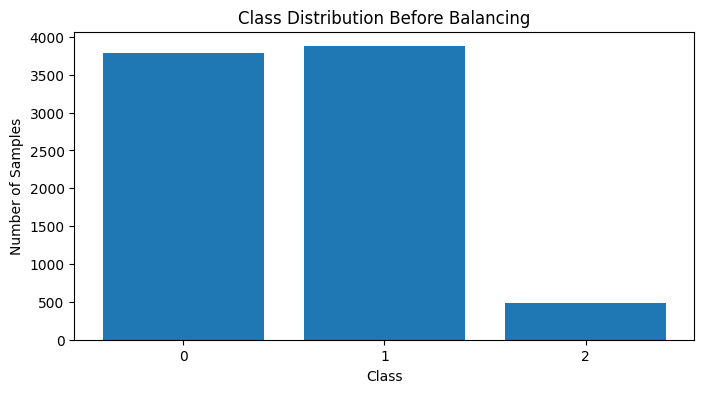

Class counts before balancing: [3791 3875  489]


In [ ]:
import matplotlib.pyplot as plt

# Count the number of instances of each class before balancing
class_counts = torch.bincount(targets_combined)

# Plot the class distribution
plt.figure(figsize=(8, 4))
plt.bar(range(len(class_counts)), class_counts.numpy(), tick_label=list(range(len(class_counts))))
plt.title("Class Distribution Before Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts before balancing:", class_counts.numpy())

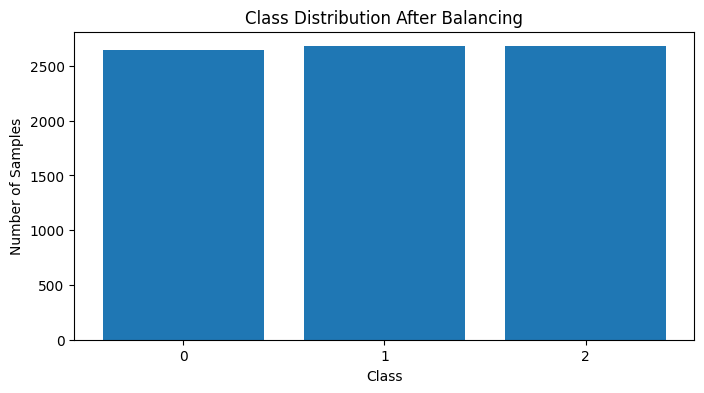

Class counts after balancing: [2645 2677 2678]


In [ ]:
# Simulate sampling
num_samples_to_check = 8000  # You can increase this number for better accuracy
sampled_indices = list(sampler)[:num_samples_to_check]
sampled_targets = targets_combined[sampled_indices]

# Count the number of instances of each class after balancing
balanced_class_counts = torch.bincount(sampled_targets)

# Plot the class distribution after balancing
plt.figure(figsize=(8, 4))
plt.bar(range(len(balanced_class_counts)), balanced_class_counts.numpy(), tick_label=list(range(len(balanced_class_counts))))
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts after balancing:", balanced_class_counts.numpy())

In [ ]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets_combined['train'], batch_size = 32, sampler=sampler),
    'val': torch.utils.data.DataLoader(image_datasets_combined['val'], batch_size = 32),
    'test': torch.utils.data.DataLoader(image_datasets_combined['test'], batch_size = 32)
}

In [ ]:
# # Check class distribution in your training set
# targets = []
# for _, labels in dataloaders['train']:
#     targets.extend(labels.cpu().numpy())
# print("Class distribution:", np.bincount(targets))

In [ ]:
len(dataloaders['train'])

255

In [ ]:
class NT_Xent(nn.Module):
    def __init__(self, temperature: float = 0.5, **kwargs):
        super().__init__()
        self.temperature = temperature
        self.eps = 1e-8
        if abs(self.temperature) < self.eps:
            raise ValueError(
                "Illegal temperature: abs({}) < 1e-8".format(self.temperature)
            )

    def forward(self, out0: torch.Tensor, out1: torch.Tensor):
        device = out0.device
        batch_size, _ = out0.shape

        out0 = nn.functional.normalize(out0, dim=1)
        out1 = nn.functional.normalize(out1, dim=1)

        out = torch.cat((out0, out1), dim=0)
        sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / self.temperature)
        mask = (
            torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=device)
        ).bool()
        sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)
        pos_sim = torch.exp(torch.sum(out0 * out1, dim=-1) / self.temperature)
        pos_sim = torch.cat((pos_sim, pos_sim), dim=0)
        loss = (-torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()
        return loss

In [ ]:
class SimCLR(nn.Module):

    def __init__(
        self,
        backbone: nn.Module,
        feature_size: int,
        projection_dim: int = 128,
        **kwargs
    ):
        super().__init__()
        self.feature_size = feature_size
        self.projection_dim = projection_dim
        self.backbone = backbone

        self.projection_head = nn.Sequential(
            nn.Sequential(nn.Linear(self.feature_size, self.feature_size), nn.BatchNorm1d(self.feature_size), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Linear(self.feature_size, self.feature_size), nn.BatchNorm1d(self.feature_size), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Linear(self.feature_size, self.feature_size), nn.BatchNorm1d(self.feature_size)))

        self.encoder = nn.Sequential(self.backbone, self.projection_head)

    def forward(self, x0: torch.Tensor, x1: torch.Tensor):
        f0 = self.backbone(x0).flatten(start_dim=1)
        out0 = self.projection_head(f0)

        f1 = self.backbone(x1).flatten(start_dim=1)
        out1 = self.projection_head(f1)

        return out0, out1

In [ ]:
backbone = models.resnet50()
num_features = backbone.fc.in_features
backbone.fc = nn.Identity()

model = SimCLR(backbone=backbone, feature_size=num_features, projection_dim=128)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
print(f"Number of Model Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Memmory Usage: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")

Number of Model Parameters: 36109376
Memmory Usage: 0.13 GB


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = NT_Xent()
ssl_transform = SimCLRViewTransform()

### SSL Training

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Initialize dictionaries to store metrics
metrics = {
    'train_loss': [],
    'val_loss': [],
}

# Parameters for Early Stopping
early_stopping_patience = 5  # Stop after 5 epochs with no improvement
best_val_loss = float('inf')
patience_counter = 0

num_epochs = 100  # Set a higher number of epochs to allow early stopping

model.load_state_dict(torch.load('/content/drive/MyDrive/model_ssl_epoch_99.pth'))

for epoch in range(100,num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = dataloaders['train']
        else:
            model.eval()  # Set model to evaluate mode
            dataloader = dataloaders['val']

        running_loss = 0.0
        running_corrects = 0
        all_labels = []
        all_preds = []

        # Iterate over data with tqdm progress bar
        for inputs, _ in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
            inputs = inputs.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            aug1 = ssl_transform(inputs)
            aug2 = ssl_transform(inputs)

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                out0, out1 = model(aug1, aug2)
                loss = criterion(out0, out1)

                # Backward pass + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)

        # Calculate metrics
        epoch_loss = running_loss / len(dataloader.dataset)

        # Save metrics
        metrics[f'{phase}_loss'].append(epoch_loss)

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}')

        # Early stopping check during validation phase
        if phase == 'val':
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                patience_counter = 0  # Reset the counter if improvement occurs
                # Save the model weights when improvement occurs
                torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_ssl_training.pth')
            else:
                patience_counter += 1

        if epoch % 10 == 0:
            # Save the model weights every 10 epochs
            torch.save(model.state_dict(), f'/content/drive/MyDrive/model_ssl_epoch_{epoch}.pth')

    print()

    # # Check for early stopping
    # if patience_counter >= early_stopping_patience:
    #     print("Early stopping triggered")
    #     break

# Specify the path to save the file in Google Drive
output_path = "/content/drive/MyDrive/training_metrics_ssl_training.txt"
with open(output_path, "w") as f:
    for key, values in metrics.items():
        f.write(f"{key}: {values}\n")

print(f"Training metrics saved to {output_path}")

Mounted at /content/drive


<ipython-input-25-7f4f818271a5>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/model_ssl_epoch_99.pth'))


Training metrics saved to /content/drive/MyDrive/training_metrics_ssl_training.txt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pickle
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Directory to save model checkpoints and metrics
checkpoint_dir = '/content/drive/MyDrive'
metrics_path = '/content/drive/MyDrive/metrics_history.pkl'
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize the model (ensure you have defined 'model' correctly before this step)
num_classes = 3  # Update as per your dataset
model.backbone.fc = nn.Linear(num_features, num_classes)
model = model.backbone.to(device)

# Define loss function and optimizer for the linear classifier
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Commented code for loading from a checkpoint (uncomment when needed)
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_30.pth')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0

# Initialize metrics history
if os.path.exists(metrics_path):
    with open(metrics_path, 'rb') as f:
        metrics = pickle.load(f)
else:
    metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Training loop with checkpoint saving every 10th epoch
num_epochs_linear = 100  # Adjust as needed

for epoch in range(30,num_epochs_linear):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    # No tqdm here for individual batches
    for inputs, labels in tqdm(dataloaders['train'], desc=f"Linear Eval Epoch {epoch+1}"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

    # Calculate precision, recall, and F1 score
    epoch_precision = precision_score(all_labels, all_preds, average='macro')
    epoch_recall = recall_score(all_labels, all_preds, average='macro')
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}")

    # Save metrics every 10th epoch
    if (epoch + 1) % 10 == 0:
        # Append metrics to the history
        metrics['loss'].append(epoch_loss)
        metrics['accuracy'].append(epoch_acc.item())
        metrics['precision'].append(epoch_precision)
        metrics['recall'].append(epoch_recall)
        metrics['f1'].append(epoch_f1)

        # Save the metrics history
        with open(metrics_path, 'wb') as f:
            pickle.dump(metrics, f)

        # Save the model checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-26-cd531a857b8b>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 30


Linear Eval Epoch 31: 100%|██████████| 255/255 [03:27<00:00,  1.23it/s]


Epoch 31 Loss: 0.0887 Acc: 0.9704 Precision: 0.9706 Recall: 0.9705 F1: 0.9706


Linear Eval Epoch 32: 100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 32 Loss: 0.0884 Acc: 0.9671 Precision: 0.9670 Recall: 0.9669 F1: 0.9670


Linear Eval Epoch 33: 100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 33 Loss: 0.0858 Acc: 0.9695 Precision: 0.9696 Recall: 0.9695 F1: 0.9695


Linear Eval Epoch 34: 100%|██████████| 255/255 [03:24<00:00,  1.24it/s]


Epoch 34 Loss: 0.0857 Acc: 0.9702 Precision: 0.9705 Recall: 0.9703 F1: 0.9704


Linear Eval Epoch 35: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 35 Loss: 0.0843 Acc: 0.9685 Precision: 0.9685 Recall: 0.9684 F1: 0.9684


Linear Eval Epoch 36: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 36 Loss: 0.0728 Acc: 0.9739 Precision: 0.9737 Recall: 0.9737 F1: 0.9737


Linear Eval Epoch 37: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 37 Loss: 0.0815 Acc: 0.9722 Precision: 0.9720 Recall: 0.9720 F1: 0.9720


Linear Eval Epoch 38: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 38 Loss: 0.0792 Acc: 0.9720 Precision: 0.9719 Recall: 0.9720 F1: 0.9720


Linear Eval Epoch 39: 100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 39 Loss: 0.0858 Acc: 0.9714 Precision: 0.9714 Recall: 0.9714 F1: 0.9714


Linear Eval Epoch 40: 100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 40 Loss: 0.0892 Acc: 0.9662 Precision: 0.9663 Recall: 0.9662 F1: 0.9662
Checkpoint saved at epoch 40


Linear Eval Epoch 41: 100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 41 Loss: 0.0790 Acc: 0.9716 Precision: 0.9717 Recall: 0.9716 F1: 0.9716


Linear Eval Epoch 42: 100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 42 Loss: 0.0864 Acc: 0.9700 Precision: 0.9701 Recall: 0.9701 F1: 0.9701


Linear Eval Epoch 43: 100%|██████████| 255/255 [03:26<00:00,  1.23it/s]


Epoch 43 Loss: 0.0920 Acc: 0.9673 Precision: 0.9674 Recall: 0.9673 F1: 0.9674


Linear Eval Epoch 44: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 44 Loss: 0.0743 Acc: 0.9750 Precision: 0.9750 Recall: 0.9750 F1: 0.9750


Linear Eval Epoch 45: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 45 Loss: 0.0802 Acc: 0.9718 Precision: 0.9718 Recall: 0.9717 F1: 0.9717


Linear Eval Epoch 46: 100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 46 Loss: 0.0714 Acc: 0.9767 Precision: 0.9768 Recall: 0.9768 F1: 0.9768


Linear Eval Epoch 47: 100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 47 Loss: 0.0811 Acc: 0.9713 Precision: 0.9716 Recall: 0.9715 F1: 0.9715


Linear Eval Epoch 48: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 48 Loss: 0.0805 Acc: 0.9707 Precision: 0.9708 Recall: 0.9709 F1: 0.9708


Linear Eval Epoch 49: 100%|██████████| 255/255 [03:23<00:00,  1.26it/s]


Epoch 49 Loss: 0.0772 Acc: 0.9734 Precision: 0.9735 Recall: 0.9735 F1: 0.9735


Linear Eval Epoch 50: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 50 Loss: 0.0706 Acc: 0.9750 Precision: 0.9750 Recall: 0.9750 F1: 0.9750
Checkpoint saved at epoch 50


Linear Eval Epoch 51: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 51 Loss: 0.0813 Acc: 0.9718 Precision: 0.9717 Recall: 0.9717 F1: 0.9717


Linear Eval Epoch 52: 100%|██████████| 255/255 [03:21<00:00,  1.26it/s]


Epoch 52 Loss: 0.0740 Acc: 0.9723 Precision: 0.9724 Recall: 0.9725 F1: 0.9724


Linear Eval Epoch 53: 100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 53 Loss: 0.0721 Acc: 0.9727 Precision: 0.9727 Recall: 0.9726 F1: 0.9726


Linear Eval Epoch 54: 100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 54 Loss: 0.0767 Acc: 0.9720 Precision: 0.9723 Recall: 0.9722 F1: 0.9722


Linear Eval Epoch 55: 100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 55 Loss: 0.0739 Acc: 0.9746 Precision: 0.9747 Recall: 0.9747 F1: 0.9747


Linear Eval Epoch 56: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 56 Loss: 0.0806 Acc: 0.9691 Precision: 0.9691 Recall: 0.9691 F1: 0.9691


Linear Eval Epoch 57: 100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 57 Loss: 0.0692 Acc: 0.9752 Precision: 0.9753 Recall: 0.9753 F1: 0.9753


Linear Eval Epoch 58: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 58 Loss: 0.0748 Acc: 0.9720 Precision: 0.9719 Recall: 0.9719 F1: 0.9719


Linear Eval Epoch 59: 100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 59 Loss: 0.0765 Acc: 0.9717 Precision: 0.9718 Recall: 0.9719 F1: 0.9718


Linear Eval Epoch 60: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 60 Loss: 0.0716 Acc: 0.9747 Precision: 0.9748 Recall: 0.9748 F1: 0.9748
Checkpoint saved at epoch 60


Linear Eval Epoch 61: 100%|██████████| 255/255 [03:24<00:00,  1.24it/s]


Epoch 61 Loss: 0.0744 Acc: 0.9750 Precision: 0.9750 Recall: 0.9750 F1: 0.9750


Linear Eval Epoch 62: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 62 Loss: 0.0746 Acc: 0.9703 Precision: 0.9706 Recall: 0.9703 F1: 0.9705


Linear Eval Epoch 63: 100%|██████████| 255/255 [03:27<00:00,  1.23it/s]


Epoch 63 Loss: 0.0723 Acc: 0.9724 Precision: 0.9725 Recall: 0.9725 F1: 0.9725


Linear Eval Epoch 64: 100%|██████████| 255/255 [03:35<00:00,  1.18it/s]


Epoch 64 Loss: 0.0700 Acc: 0.9749 Precision: 0.9749 Recall: 0.9749 F1: 0.9749


Linear Eval Epoch 65: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 65 Loss: 0.0714 Acc: 0.9739 Precision: 0.9738 Recall: 0.9739 F1: 0.9738


Linear Eval Epoch 66: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 66 Loss: 0.0714 Acc: 0.9758 Precision: 0.9759 Recall: 0.9758 F1: 0.9758


Linear Eval Epoch 67: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 67 Loss: 0.0743 Acc: 0.9731 Precision: 0.9731 Recall: 0.9732 F1: 0.9731


Linear Eval Epoch 68: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 68 Loss: 0.0698 Acc: 0.9756 Precision: 0.9756 Recall: 0.9754 F1: 0.9755


Linear Eval Epoch 69: 100%|██████████| 255/255 [03:21<00:00,  1.26it/s]


Epoch 69 Loss: 0.0648 Acc: 0.9768 Precision: 0.9768 Recall: 0.9768 F1: 0.9768


Linear Eval Epoch 70: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 70 Loss: 0.0707 Acc: 0.9730 Precision: 0.9732 Recall: 0.9730 F1: 0.9731
Checkpoint saved at epoch 70


Linear Eval Epoch 71: 100%|██████████| 255/255 [03:23<00:00,  1.26it/s]


Epoch 71 Loss: 0.0636 Acc: 0.9767 Precision: 0.9766 Recall: 0.9765 F1: 0.9765


Linear Eval Epoch 72: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 72 Loss: 0.0770 Acc: 0.9701 Precision: 0.9702 Recall: 0.9702 F1: 0.9702


Linear Eval Epoch 73: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 73 Loss: 0.0661 Acc: 0.9766 Precision: 0.9767 Recall: 0.9767 F1: 0.9767


Linear Eval Epoch 74: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 74 Loss: 0.0742 Acc: 0.9730 Precision: 0.9730 Recall: 0.9730 F1: 0.9730


Linear Eval Epoch 75: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 75 Loss: 0.0688 Acc: 0.9757 Precision: 0.9759 Recall: 0.9758 F1: 0.9759


Linear Eval Epoch 76: 100%|██████████| 255/255 [03:21<00:00,  1.26it/s]


Epoch 76 Loss: 0.0691 Acc: 0.9750 Precision: 0.9749 Recall: 0.9749 F1: 0.9749


Linear Eval Epoch 77: 100%|██████████| 255/255 [03:21<00:00,  1.26it/s]


Epoch 77 Loss: 0.0644 Acc: 0.9776 Precision: 0.9774 Recall: 0.9774 F1: 0.9774


Linear Eval Epoch 78: 100%|██████████| 255/255 [03:21<00:00,  1.27it/s]


Epoch 78 Loss: 0.0660 Acc: 0.9782 Precision: 0.9781 Recall: 0.9781 F1: 0.9781


Linear Eval Epoch 79: 100%|██████████| 255/255 [03:20<00:00,  1.27it/s]


Epoch 79 Loss: 0.0645 Acc: 0.9762 Precision: 0.9762 Recall: 0.9762 F1: 0.9762


Linear Eval Epoch 80: 100%|██████████| 255/255 [03:21<00:00,  1.27it/s]


Epoch 80 Loss: 0.0613 Acc: 0.9801 Precision: 0.9801 Recall: 0.9802 F1: 0.9801
Checkpoint saved at epoch 80


Linear Eval Epoch 81: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 81 Loss: 0.0737 Acc: 0.9713 Precision: 0.9714 Recall: 0.9714 F1: 0.9714


Linear Eval Epoch 82: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 82 Loss: 0.0678 Acc: 0.9761 Precision: 0.9763 Recall: 0.9763 F1: 0.9763


Linear Eval Epoch 83: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 83 Loss: 0.0671 Acc: 0.9751 Precision: 0.9752 Recall: 0.9752 F1: 0.9752


Linear Eval Epoch 84: 100%|██████████| 255/255 [03:21<00:00,  1.26it/s]


Epoch 84 Loss: 0.0671 Acc: 0.9744 Precision: 0.9745 Recall: 0.9744 F1: 0.9744


Linear Eval Epoch 85: 100%|██████████| 255/255 [03:21<00:00,  1.26it/s]


Epoch 85 Loss: 0.0668 Acc: 0.9768 Precision: 0.9768 Recall: 0.9767 F1: 0.9767


Linear Eval Epoch 86: 100%|██████████| 255/255 [03:21<00:00,  1.26it/s]


Epoch 86 Loss: 0.0688 Acc: 0.9740 Precision: 0.9741 Recall: 0.9742 F1: 0.9742


Linear Eval Epoch 87: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 87 Loss: 0.0594 Acc: 0.9795 Precision: 0.9793 Recall: 0.9794 F1: 0.9793


Linear Eval Epoch 88: 100%|██████████| 255/255 [03:21<00:00,  1.26it/s]


Epoch 88 Loss: 0.0708 Acc: 0.9740 Precision: 0.9740 Recall: 0.9740 F1: 0.9740


Linear Eval Epoch 89: 100%|██████████| 255/255 [03:21<00:00,  1.26it/s]


Epoch 89 Loss: 0.0645 Acc: 0.9777 Precision: 0.9778 Recall: 0.9779 F1: 0.9778


Linear Eval Epoch 90: 100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 90 Loss: 0.0626 Acc: 0.9787 Precision: 0.9787 Recall: 0.9788 F1: 0.9788
Checkpoint saved at epoch 90


Linear Eval Epoch 91: 100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 91 Loss: 0.0604 Acc: 0.9788 Precision: 0.9791 Recall: 0.9790 F1: 0.9791


Linear Eval Epoch 92: 100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 92 Loss: 0.0635 Acc: 0.9776 Precision: 0.9776 Recall: 0.9776 F1: 0.9775


Linear Eval Epoch 93: 100%|██████████| 255/255 [03:23<00:00,  1.26it/s]


Epoch 93 Loss: 0.0641 Acc: 0.9757 Precision: 0.9757 Recall: 0.9757 F1: 0.9757


Linear Eval Epoch 94: 100%|██████████| 255/255 [03:23<00:00,  1.26it/s]


Epoch 94 Loss: 0.0611 Acc: 0.9801 Precision: 0.9801 Recall: 0.9802 F1: 0.9801


Linear Eval Epoch 95: 100%|██████████| 255/255 [03:21<00:00,  1.27it/s]


Epoch 95 Loss: 0.0650 Acc: 0.9740 Precision: 0.9741 Recall: 0.9741 F1: 0.9741


Linear Eval Epoch 96: 100%|██████████| 255/255 [03:21<00:00,  1.26it/s]


Epoch 96 Loss: 0.0543 Acc: 0.9830 Precision: 0.9830 Recall: 0.9830 F1: 0.9830


Linear Eval Epoch 97: 100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 97 Loss: 0.0588 Acc: 0.9815 Precision: 0.9814 Recall: 0.9814 F1: 0.9814


Linear Eval Epoch 98: 100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 98 Loss: 0.0602 Acc: 0.9785 Precision: 0.9787 Recall: 0.9787 F1: 0.9787


Linear Eval Epoch 99: 100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 99 Loss: 0.0643 Acc: 0.9765 Precision: 0.9765 Recall: 0.9764 F1: 0.9765


Linear Eval Epoch 100: 100%|██████████| 255/255 [03:22<00:00,  1.26it/s]


Epoch 100 Loss: 0.0602 Acc: 0.9790 Precision: 0.9790 Recall: 0.9791 F1: 0.9790
Checkpoint saved at epoch 100


Mounted at /content/drive


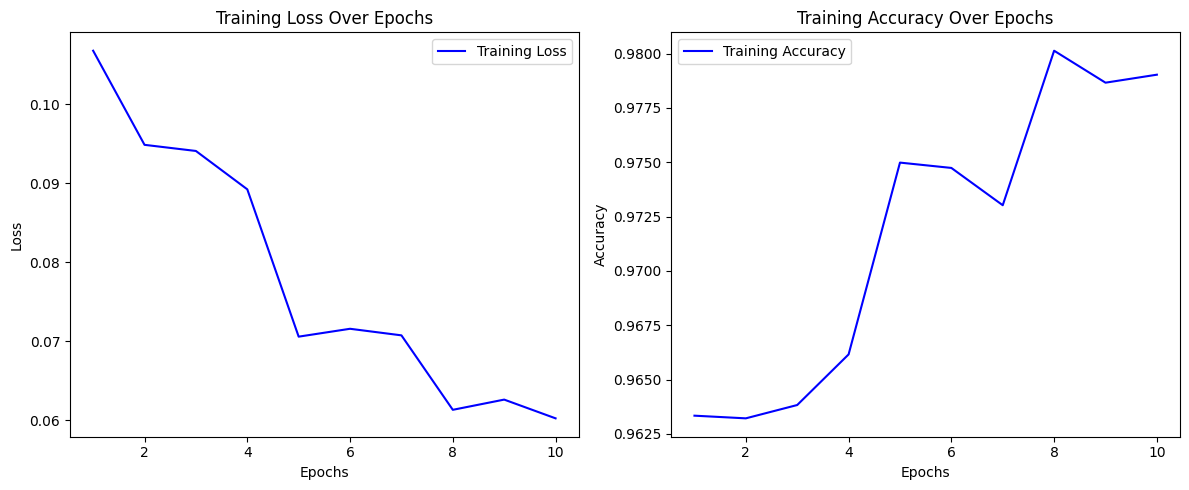

In [4]:
import matplotlib.pyplot as plt
import pickle

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

metrics_path = '/content/drive/MyDrive/metrics_history.pkl'
# Load the saved metrics history
with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)

# Extract metrics
loss_history = metrics['loss']
accuracy_history = metrics['accuracy']

# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


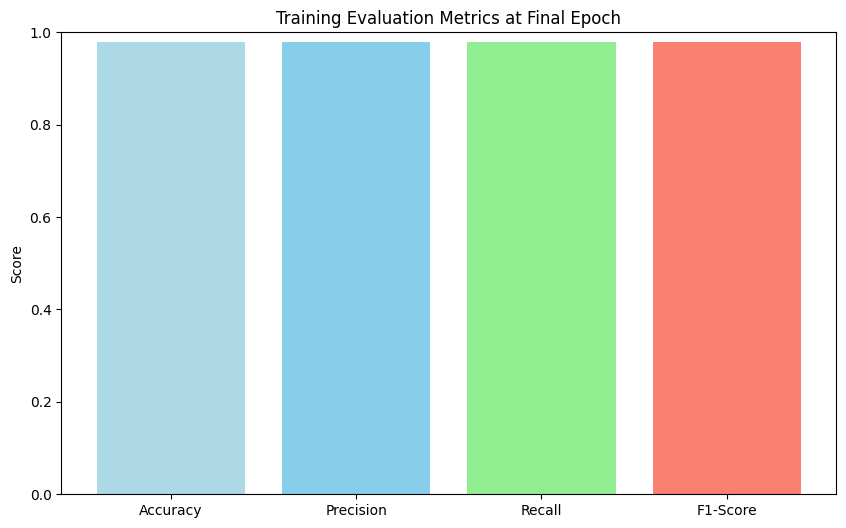

In [ ]:
import matplotlib.pyplot as plt

# Assuming you've also saved precision, recall, and F1-score metrics
# If not, ensure these metrics are included when saving during training

# Load the saved metrics history
with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)

# Extract metrics
accuracy_history = metrics['accuracy']
precision_history = metrics['precision']
recall_history = metrics['recall']
f1_history = metrics['f1']

# Extract the final epoch's values
final_accuracy = accuracy_history[-1]
final_precision = precision_history[-1]
final_recall = recall_history[-1]
final_f1 = f1_history[-1]

# Plotting accuracy, precision, recall, and F1-score
plt.figure(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [final_accuracy, final_precision, final_recall, final_f1]  # Only plot the last epoch's values

# Plot the metrics
plt.bar(metrics, scores, color=['lightblue', 'skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Score')
plt.ylim([0, 1])  # Assuming the metrics are normalized (between 0 and 1)
plt.title('Training Evaluation Metrics at Final Epoch')

plt.show()
